<a href="https://colab.research.google.com/github/anjali88/HFT-ML/blob/master/ALL__AIHFT_RDSB_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mxnet

In [ ]:
pip install utils

In [ ]:
import pandas as pd
import numpy as np
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import time
import datetime
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math

#Normalising imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
import xgboost as xgb

#Performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")

#Setting up mxnet model Need this to create an ARIMA model and Fourier series model easily
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

##DATA ACQUISITION



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving RDSB.xlsx to RDSB.xlsx


##Data Exploration (EDA)

In [ ]:
import io
dataset_ex_df = pd.read_excel(io.BytesIO(uploaded['RDSB.xlsx']))
dataset_ex_df.head(3)

Dates    Open   Close    High     Low       Value  Volume
0 2018-02-14 08:00:00  2319.0  2315.5  2319.0  2315.5  64152800.0   27677
1 2018-02-14 08:01:00  2316.5  2314.0  2316.5  2312.5  39831632.0   17206
2 2018-02-14 08:02:00  2311.5  2306.0  2312.0  2305.0  38951624.0   16871

In [ ]:
print('There are {} number of observations in the dataset.'.format(dataset_ex_df.shape[0]))

There are 66932 number of observations in the dataset.


In [ ]:
dataset_ex_df.describe()

Open         Close  ...         Value        Volume
count  66932.000000  66932.000000  ...  6.693200e+04  6.693200e+04
mean    2545.859664   2545.876266  ...  2.082363e+07  8.157015e+03
std      179.411875    179.426086  ...  1.537493e+08  6.091065e+04
min     2194.500000   2194.500000  ...  2.283000e+03  1.000000e+00
25%     2331.000000   2331.500000  ...  4.144341e+06  1.642000e+03
50%     2609.000000   2609.000000  ...  9.087163e+06  3.566000e+03
75%     2690.500000   2690.500000  ...  1.812303e+07  7.087000e+03
max     2844.500000   2844.500000  ...  1.387216e+10  5.661201e+06

[8 rows x 6 columns]

In [ ]:
num_training_days = int(dataset_ex_df.shape[0]*.75)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 50199. Number of test days: 16733.


**1. Market Trend**

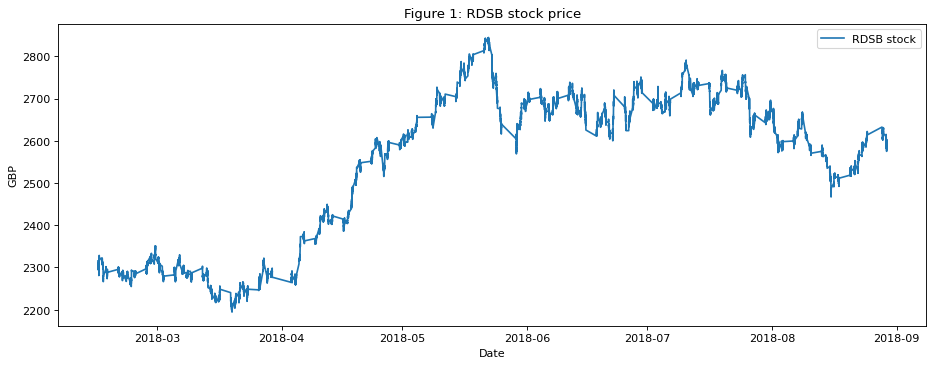

In [ ]:
plt.figure(figsize=(14, 5), dpi=80)
plt.plot(dataset_ex_df['Dates'], dataset_ex_df['Close'], label='RDSB stock')
plt.xlabel('Date')
plt.ylabel('GBP')
plt.title('Figure 1: RDSB stock price')
plt.legend()
plt.show()

**2. Test for data stationarity - Dickey Fuller Test**
1.   Test Statistic
2.   p-Value
3.   Lags used
4.   Critical value(1%)
5.   Critical value(5%)
6.   Critical value(10%)
7.   Rolling mean
9.   Standard Deviation


In [ ]:
import statsmodels.tsa.stattools as ts

In [ ]:
def dftest(timeseries):
    """This code is from a Metis lecture on testing for stationary data with the
    Dickey Fuller test for time series analysis. It takes in a time series and outputs statistics and graphics
    If the p value is <.05, then the data passes the test and is ready for ARMA models."""
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test RDSB data stationarity:

Test Statistic             -1.429702
p-value                     0.567957
Lags Used                  26.000000
Observations Used       66905.000000
Critical Value (1%)        -3.430448
Critical Value (5%)        -2.861583
Critical Value (10%)       -2.566793
dtype: float64


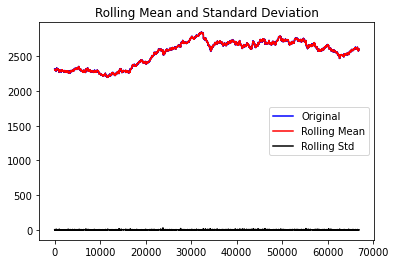

None


In [ ]:
print("Test RDSB data stationarity:\n")
print(dftest(dataset_ex_df.Close))

In [ ]:
dataset_ex_dfcopy = dataset_ex_df.copy()

> *Log Transformation*

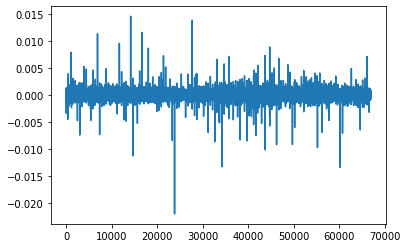

In [ ]:
dataset_ex_dfcopy['Close_log'] = np.log(dataset_ex_dfcopy['Close'])
dataset_ex_dfcopy['Close_log_diff'] = dataset_ex_dfcopy['Close_log'] - dataset_ex_dfcopy['Close_log'].shift(1)
dataset_ex_dfcopy['Close_log_diff'].dropna().plot()

In [ ]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

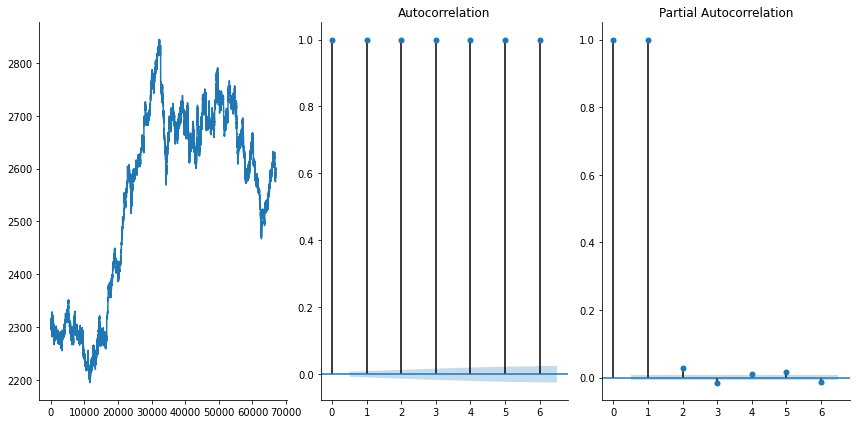

In [ ]:
plots(dataset_ex_df.Close, lags=6)

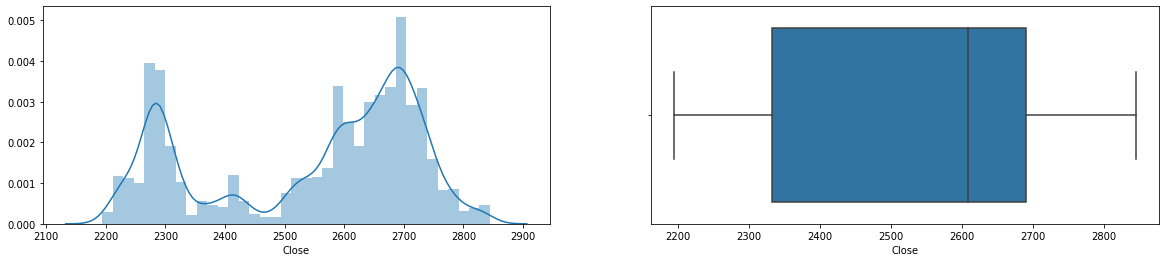

In [ ]:
f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.distplot(dataset_ex_df['Close'])
f.add_subplot(1,2,2)
sns.boxplot(dataset_ex_df['Close'])

#Feature Generation

**1. Correlated Assets**

In [ ]:
from google.colab import files
uploaded1 = files.upload()

Saving CA.xlsx to CA.xlsx


In [ ]:
import io
dataset_CA = pd.read_excel(io.BytesIO(uploaded1['CA.xlsx']))
dataset_CA.head(3)

Dates    RDSB     AAL     ABF  ...     UU     VOD     WPP     WTB
0 2018-02-14 08:00:00  2315.5  1679.8  2611.0  ...  665.8  201.45  1339.5  3815.0
1 2018-02-14 08:01:00  2314.0  1680.8  2612.0  ...  665.8  201.55  1345.5  3818.0
2 2018-02-14 08:02:00  2306.0  1679.0  2611.0  ...  664.6  201.10  1343.0  3815.0

[3 rows x 101 columns]

In [ ]:
#print shape of data with CA 
dataset_CA.shape

(68935, 101)

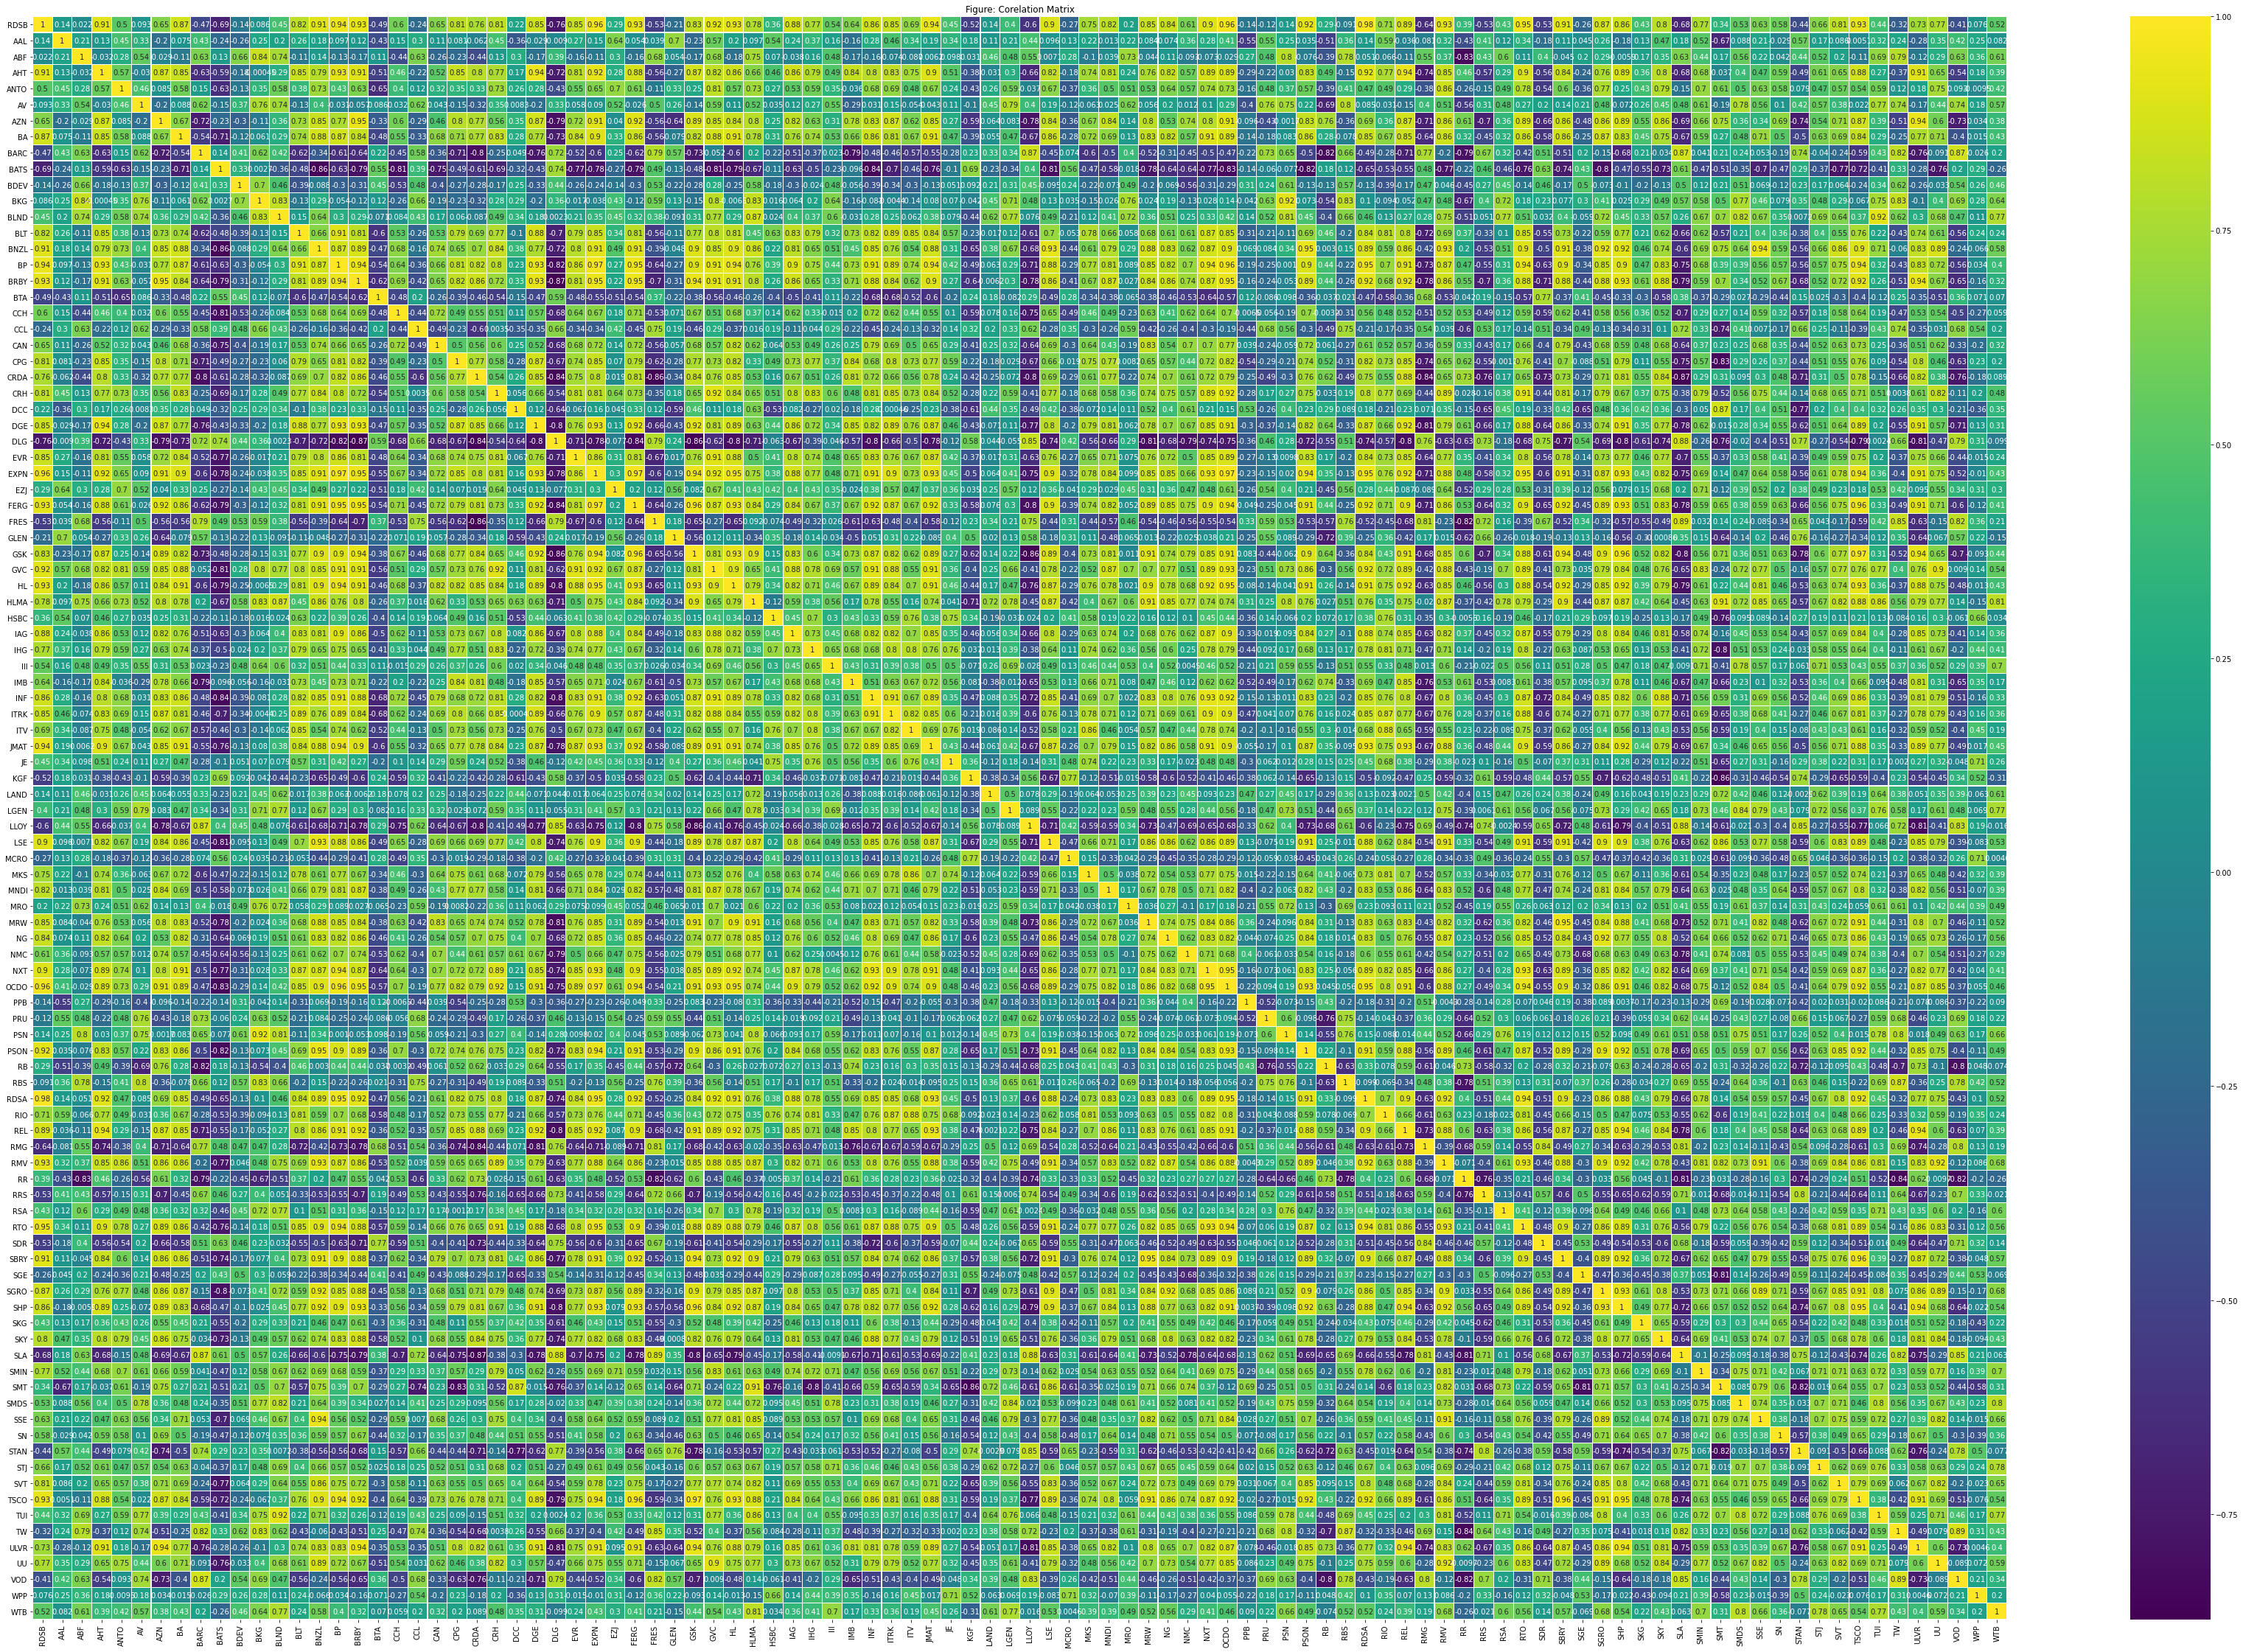

In [ ]:
import seaborn as sns
cor1=dataset_CA.corr(method='pearson')
plt.figure(figsize=(60, 40))
plt.title("Figure: Corelation Matrix")
cm=plt.cm.viridis
corr = sns.heatmap(cor1,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

In [ ]:
cor_target_RDSB = abs(cor1["RDSB"])
relevant_features_RDSB = cor_target_RDSB[cor_target_RDSB>0.70]
irrelevant_features_RDSB = cor_target_RDSB[cor_target_RDSB<0.70]
print("Relevant Features_RDSB:\n")
print(relevant_features_RDSB.head(10))
print("Irrelevant Features_RDSB:\n")
print(irrelevant_features_RDSB.head(10))

Relevant Features_RDSB:

RDSB    1.000000
AHT     0.913464
BA      0.869333
BLT     0.816134
BNZL    0.909186
BP      0.944658
BRBY    0.929920
CPG     0.808736
CRDA    0.761380
CRH     0.813739
Name: RDSB, dtype: float64
Irrelevant Features_RDSB:

AAL     0.140783
ABF     0.022348
ANTO    0.503737
AV      0.092976
AZN     0.650167
BARC    0.466856
BATS    0.693722
BDEV    0.140610
BKG     0.086123
BLND    0.449712
Name: RDSB, dtype: float64


In [ ]:
print(relevant_features_RDSB.index.to_list())

['RDSB', 'AHT', 'BA', 'BLT', 'BNZL', 'BP', 'BRBY', 'CPG', 'CRDA', 'CRH', 'DGE', 'DLG', 'EVR', 'EXPN', 'FERG', 'GSK', 'GVC', 'HL', 'HLMA', 'IAG', 'IHG', 'INF', 'ITRK', 'JMAT', 'LSE', 'MKS', 'MNDI', 'MRW', 'NG', 'NXT', 'OCDO', 'PSON', 'RDSA', 'RIO', 'REL', 'RMV', 'RTO', 'SBRY', 'SGRO', 'SHP', 'SKY', 'SMIN', 'SVT', 'TSCO', 'ULVR', 'UU']


In [ ]:
print(irrelevant_features_RDSB.index.to_list())

['AAL', 'ABF', 'ANTO', 'AV', 'AZN', 'BARC', 'BATS', 'BDEV', 'BKG', 'BLND', 'BTA', 'CCH', 'CCL', 'CAN', 'DCC', 'EZJ', 'FRES', 'GLEN', 'HSBC', 'III', 'IMB', 'ITV', 'JE', 'KGF', 'LAND', 'LGEN', 'LLOY', 'MCRO', 'MRO', 'NMC', 'PPB', 'PRU', 'PSN', 'RB', 'RBS', 'RMG', 'RR', 'RRS', 'RSA', 'SDR', 'SGE', 'SKG', 'SLA', 'SMT', 'SMDS', 'SSE', 'SN', 'STAN', 'STJ', 'TUI', 'TW', 'VOD', 'WPP', 'WTB']


**2. Technical Indicators**

In [ ]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

In [ ]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)
dataset_TI_df.head(5)

Dates    Open   Close  ...  lower_band          ema  momentum
0 2018-02-14 08:00:00  2319.0  2315.5  ...         NaN  2315.500000    22.155
1 2018-02-14 08:01:00  2316.5  2314.0  ...         NaN  2314.375000    22.140
2 2018-02-14 08:02:00  2311.5  2306.0  ...         NaN  2308.576923    22.060
3 2018-02-14 08:03:00  2306.5  2306.5  ...         NaN  2307.175000    22.065
4 2018-02-14 08:04:00  2309.0  2309.0  ...         NaN  2308.396694    22.090

[5 rows x 17 columns]

In [ ]:
def plot_technical_indicators(dataset, last_mins):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_mins
    
    dataset = dataset.iloc[-last_mins:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for RDSB - last {} mins.'.format(last_mins))
    plt.ylabel('GBP')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

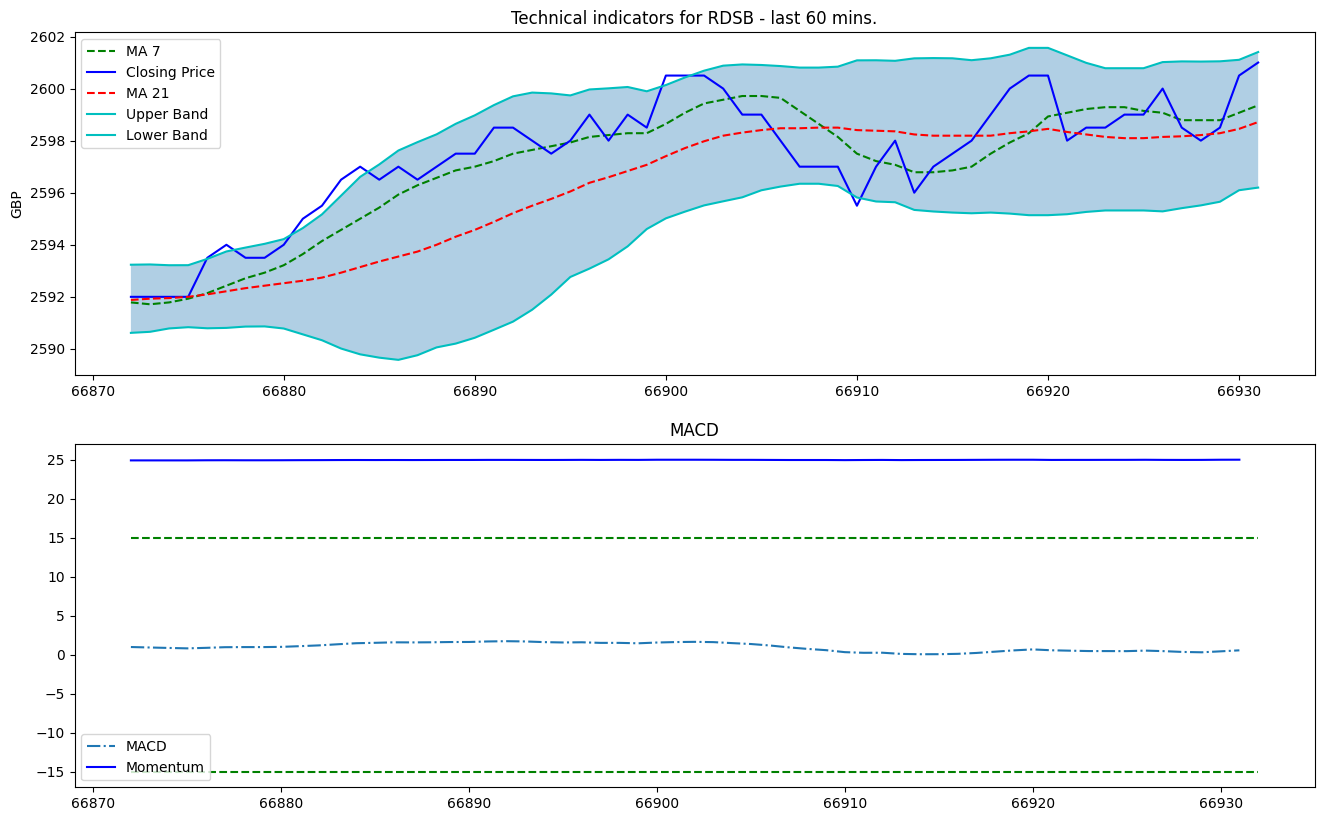

In [ ]:
plot_technical_indicators(dataset_TI_df, 60)

**3. Time Series Analysis using Fourier Transform**

In [ ]:
data_FT = dataset_ex_df[['Dates', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

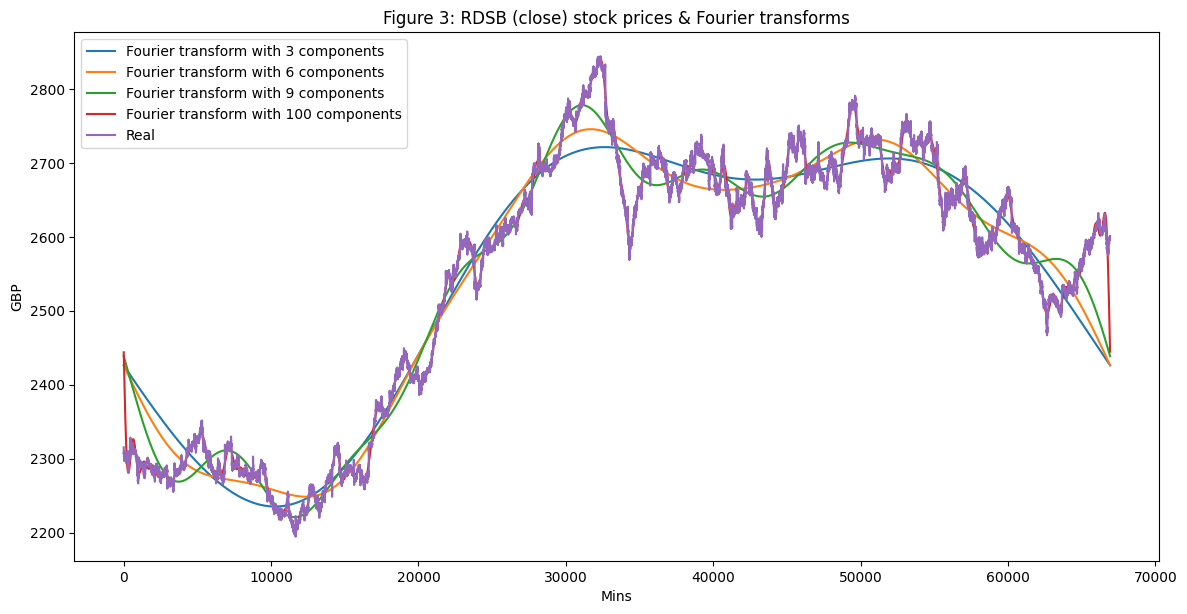

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Mins')
plt.ylabel('GBP')
plt.title('Figure 3: RDSB (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [ ]:
def get_fourier(dataset):
    data_FT = dataset[['Dates', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [ ]:
dataset_TI_df = get_fourier(dataset_ex_df)
dataset_TI_df.head(3)

Dates    Open   Close  ...          ema  momentum  Fourier
0 2018-02-14 08:00:00  2319.0  2315.5  ...  2315.500000    22.155   2315.5
1 2018-02-14 08:01:00  2316.5  2314.0  ...  2314.375000    22.140   2314.0
2 2018-02-14 08:02:00  2311.5  2306.0  ...  2308.576923    22.060   2306.0

[3 rows x 18 columns]

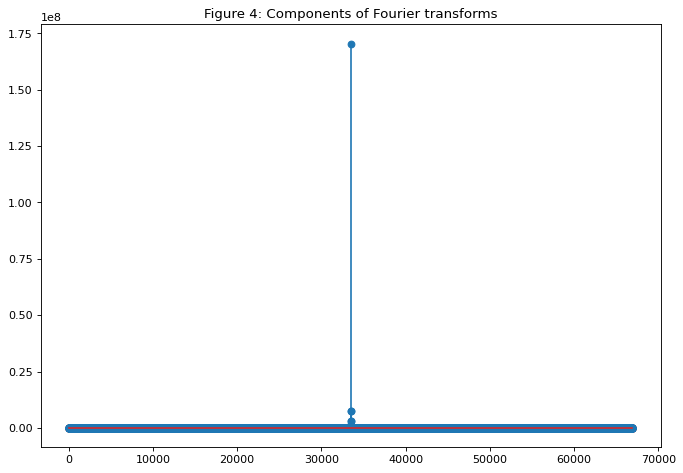

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

**4. ARIMA model as a feature**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                66931
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -116010.118
Method:                       css-mle   S.D. of innovations              1.369
Date:                Sat, 22 Aug 2020   AIC                         232034.236
Time:                        11:40:24   BIC                         232098.016
Sample:                             1   HQIC                        232053.948
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.005      0.841      0.400      -0.006       0.014
ar.L1.D.Close    -0.0303      0.004     -7.835      0.000      -0.038      -0.023
ar.L2.D.Close  1.055e-05      0.004     

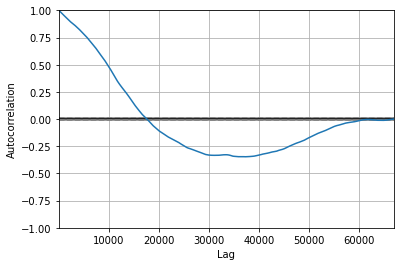

<Figure size 800x560 with 0 Axes>

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

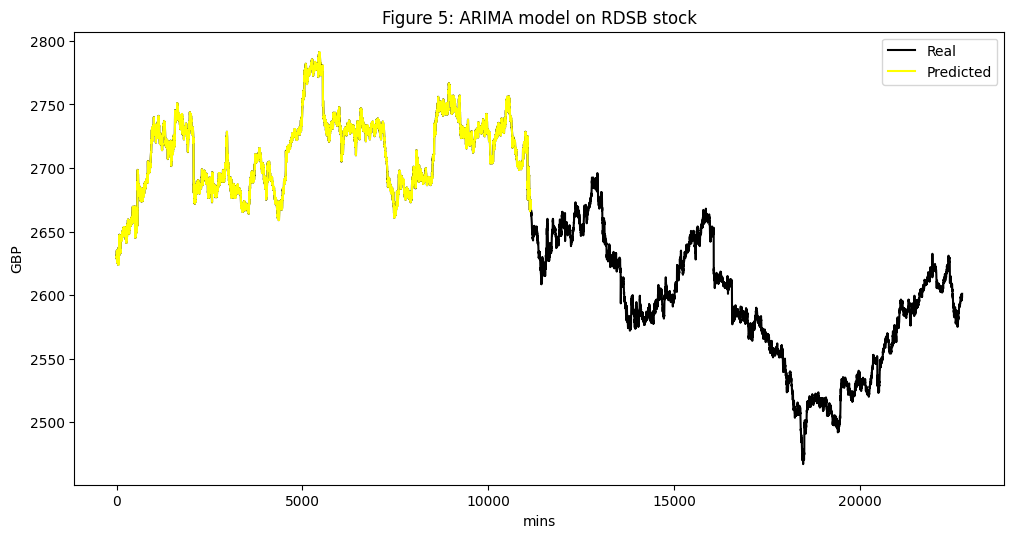

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('mins')
plt.ylabel('GBP')
plt.title('Figure 5: ARIMA model on RDSB stock')
plt.legend()
plt.show()

In [ ]:
dataset_ex_df.head(3)

Dates    Open   Close  ...          ema  momentum  Fourier
0 2018-02-14 08:00:00  2319.0  2315.5  ...  2315.500000    22.155   2315.5
1 2018-02-14 08:01:00  2316.5  2314.0  ...  2314.375000    22.140   2314.0
2 2018-02-14 08:02:00  2311.5  2306.0  ...  2308.576923    22.060   2306.0

[3 rows x 18 columns]

#Add correlated assets as features

In [ ]:
dataset_ex_df['AHT'] = dataset_CA['AHT']
dataset_ex_df['BA'] = dataset_CA['BA']
dataset_ex_df['BLT'] = dataset_CA['BLT']
dataset_ex_df['BNZL'] = dataset_CA['BNZL']
dataset_ex_df['BRBY'] = dataset_CA['BRBY']
dataset_ex_df['CPG'] = dataset_CA['CPG']
dataset_ex_df['CRDA'] = dataset_CA['CRDA']
dataset_ex_df['CRH'] = dataset_CA['CRH']
dataset_ex_df['DGE'] = dataset_CA['DGE']
dataset_ex_df['DLG'] = dataset_CA['DLG']
dataset_ex_df['EVR'] = dataset_CA['EVR']
dataset_ex_df['EXPN'] = dataset_CA['EXPN']
dataset_ex_df['FERG'] = dataset_CA['FERG']
dataset_ex_df['GSK'] = dataset_CA['GSK']
dataset_ex_df['GVC'] = dataset_CA['GVC']
dataset_ex_df['HL'] = dataset_CA['HL']
dataset_ex_df['HLMA'] = dataset_CA['HLMA']
dataset_ex_df['IAG'] = dataset_CA['IAG']
dataset_ex_df['IHG'] = dataset_CA['IHG']
dataset_ex_df['INF'] = dataset_CA['INF']
dataset_ex_df['ITRK'] = dataset_CA['ITRK']
dataset_ex_df['JMAT'] = dataset_CA['JMAT']
dataset_ex_df['LSE'] = dataset_CA['LSE']
dataset_ex_df['MKS'] = dataset_CA['MKS']
dataset_ex_df['MNDI'] = dataset_CA['MNDI']
dataset_ex_df['MRW'] = dataset_CA['MRW']
dataset_ex_df['NG'] = dataset_CA['NG']
dataset_ex_df['NXT'] = dataset_CA['NXT']
dataset_ex_df['OCDO'] = dataset_CA['OCDO']
dataset_ex_df['PSON'] = dataset_CA['PSON']
dataset_ex_df['RDSA'] = dataset_CA['RDSA']
dataset_ex_df['RTO'] = dataset_CA['RTO']
dataset_ex_df['RIO'] = dataset_CA['RIO']
dataset_ex_df['REL'] = dataset_CA['REL']
dataset_ex_df['RMV'] = dataset_CA['RMV']
dataset_ex_df['SBRY'] = dataset_CA['SBRY']
dataset_ex_df['SGRO'] = dataset_CA['SGRO']
dataset_ex_df['SHP'] = dataset_CA['SHP']
dataset_ex_df['SKY'] = dataset_CA['SKY']
dataset_ex_df['SMIN'] = dataset_CA['SMIN']
dataset_ex_df['SVT'] = dataset_CA['SVT']
dataset_ex_df['TSCO'] = dataset_CA['TSCO']
dataset_ex_df['ULVR'] = dataset_CA['ULVR']
dataset_ex_df['UU'] = dataset_CA['UU']
print(dataset_ex_df.head(2))
print('Shape of datset after adding all features')
print(dataset_ex_df.shape)

                Dates    Open   Close    High  ...     SVT   TSCO    ULVR     UU
0 2018-02-14 08:00:00  2319.0  2315.5  2319.0  ...  1731.5  204.0  3797.5  665.8
1 2018-02-14 08:01:00  2316.5  2314.0  2316.5  ...  1726.0  204.1  3800.5  665.8

[2 rows x 62 columns]
Shape of datset after adding all features
(66932, 62)


In [ ]:
dataset_ex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66932 entries, 0 to 66931
Data columns (total 62 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Dates       66932 non-null  datetime64[ns]
 1   Open        66932 non-null  float64       
 2   Close       66932 non-null  float64       
 3   High        66932 non-null  float64       
 4   Low         66932 non-null  float64       
 5   Value       66932 non-null  float64       
 6   Volume      66932 non-null  int64         
 7   ma7         66926 non-null  float64       
 8   ma21        66912 non-null  float64       
 9   26ema       66932 non-null  float64       
 10  12ema       66932 non-null  float64       
 11  MACD        66932 non-null  float64       
 12  20sd        66913 non-null  float64       
 13  upper_band  66913 non-null  float64       
 14  lower_band  66913 non-null  float64       
 15  ema         66932 non-null  float64       
 16  momentum    66932 non-

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Total dataset has 66932 samples, and 62 features.


#Feature Selection

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:62]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [ ]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_ex_df)

In [ ]:
regressor1 = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor1.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[12:16:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
eval_result1 = regressor1.evals_result()

In [ ]:
training_rounds1 = range(len(eval_result1['validation_0']['rmse']))

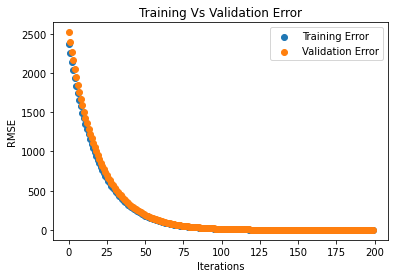

In [ ]:
plt.scatter(x=training_rounds1,y=eval_result1['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds1,y=eval_result1['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

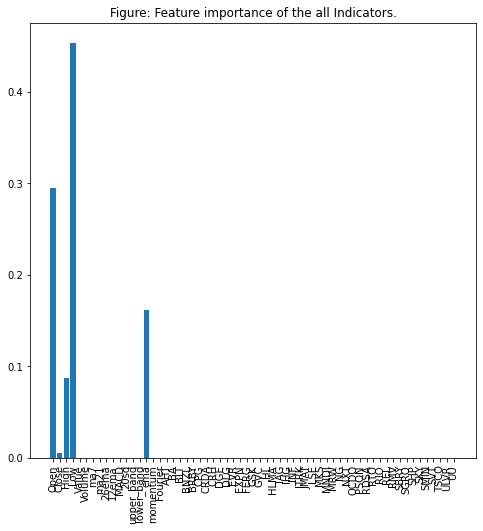

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure: Feature importance of the all Indicators.')
plt.show()

#Pre-Processing

*Scenario 1*

In [ ]:
#Five most significant features
dataset_S1 = dataset_ex_df[['Dates','Open','Close','High','Low','ema']]
dataset_S1.fillna(0, inplace=True)
dataset_S1.head(3)
                               

Dates    Open   Close    High     Low          ema
0 2018-02-14 08:00:00  2319.0  2315.5  2319.0  2315.5  2315.500000
1 2018-02-14 08:01:00  2316.5  2314.0  2316.5  2312.5  2314.375000
2 2018-02-14 08:02:00  2311.5  2306.0  2312.0  2305.0  2308.576923

In [ ]:
dataset_S1.shape

(66932, 6)

#Optimal-Modeling Filter

**1.Optimal ML model for Predicting Stock Price Movement Direction**


1.   Trigger1 -> TA1-> Request1 -> Layer1 -> Train LSTM, XGBoost 
2.   Select ML model with optimal performance metrics for lowest execution time
3.   Test optimal ML model



*Scenario-1*

In [ ]:
dataset = dataset_S1.drop(['Dates'],axis=1)
dataset.head(3)

Open   Close    High     Low          ema
0  2319.0  2315.5  2319.0  2315.5  2315.500000
1  2316.5  2314.0  2316.5  2312.5  2314.375000
2  2311.5  2306.0  2312.0  2305.0  2308.576923

In [ ]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [ ]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [ ]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [ ]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
ORDSB_avg = dataset.mean(axis = 1)
RDSB_avg = dataset[['High', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

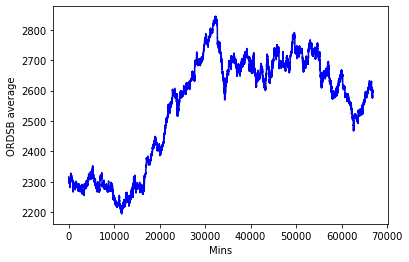

In [ ]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(ORDSB_avg, 'yellow', label = 'ORDSB avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Mins')
plt.ylabel('ORDSB average')
plt.show()

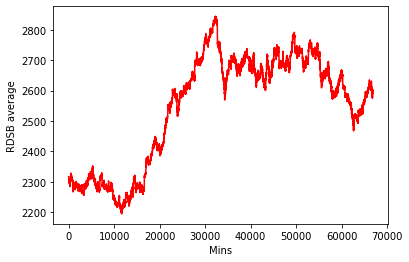

In [ ]:
plt.plot(RDSB_avg, 'red', label = 'RDSB avg')
plt.xlabel('Mins')
plt.ylabel('RDSB average')
plt.show()

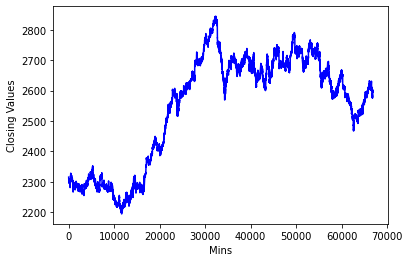

In [ ]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Mins')
plt.ylabel('Closing Values')
plt.show()

In [ ]:
# PREPARATION OF TIME SERIES DATASE
ORDSB_avg = np.reshape(ORDSB_avg.values, (len(ORDSB_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
ORDSB_avg = scaler.fit_transform(ORDSB_avg)

In [ ]:
ORDSB_avg.shape

(66932, 1)

In [ ]:
# TRAIN-TEST SPLIT
train_ORDSB = int(len(ORDSB_avg) * 0.75)
test_ORDSB = len(ORDSB_avg) - train_ORDSB
train_ORDSB, test_ORDSB = ORDSB_avg[0:train_ORDSB,:], ORDSB_avg[train_ORDSB:len(ORDSB_avg),:]

In [ ]:
ORDSB_avg.shape

(66932, 1)

In [ ]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_ORDSB, 1)
testX, testY = new_dataset(test_ORDSB, 1)

In [ ]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [ ]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [ ]:
# MODEL COMPILING AND TRAINING
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae']) 
print ('compilation time : ', time.time() - start)
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

compilation time :  0.024029970169067383
Epoch 1/50
50197/50197 - 83s - loss: 4.8019e-04 - mae: 0.0049
Epoch 2/50
50197/50197 - 86s - loss: 1.4575e-05 - mae: 0.0026
Epoch 3/50
50197/50197 - 86s - loss: 1.1819e-05 - mae: 0.0024
Epoch 4/50
50197/50197 - 82s - loss: 1.1738e-05 - mae: 0.0023
Epoch 5/50
50197/50197 - 82s - loss: 1.1324e-05 - mae: 0.0023
Epoch 6/50
50197/50197 - 84s - loss: 1.0375e-05 - mae: 0.0022
Epoch 7/50
50197/50197 - 94s - loss: 9.9135e-06 - mae: 0.0022
Epoch 8/50
50197/50197 - 90s - loss: 9.1631e-06 - mae: 0.0021
Epoch 9/50
50197/50197 - 83s - loss: 9.0245e-06 - mae: 0.0021
Epoch 10/50
50197/50197 - 82s - loss: 8.2115e-06 - mae: 0.0020
Epoch 11/50
50197/50197 - 83s - loss: 8.0083e-06 - mae: 0.0020
Epoch 12/50
50197/50197 - 83s - loss: 7.9860e-06 - mae: 0.0020
Epoch 13/50
50197/50197 - 86s - loss: 7.5033e-06 - mae: 0.0019
Epoch 14/50
50197/50197 - 83s - loss: 7.5456e-06 - mae: 0.0019
Epoch 15/50
50197/50197 - 82s - loss: 7.2735e-06 - mae: 0.0019
Epoch 16/50
50197/50197

In [ ]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

1046/1046 [==============================] - 1s 1ms/step - loss: 3.5191e-06 - mae: 0.0014
Mean Absolute Error for Y: [3.5190901144233067e-06, 0.0013668403262272477]


In [ ]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# TRAINING mse,rmse,mae, r2_score
trainScore1 = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train mse : %.2f' % (trainScore1))
trainScore2 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train rmse : %.2f' % (trainScore2))
trainScore3 = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train mae : %.2f' % (trainScore3))
trainScore4 = r2_score(trainY[0], trainPredict[:,0])
print('Train r2_score : %.2f' % (trainScore4))


Train mse : 1.67
Train rmse : 1.29
Train mae : 0.92
Train r2_score : 1.00


In [ ]:
# TEST RMSE
testScore1 = mean_squared_error(testY[0], testPredict[:,0])
print('Test MSE: %.2f' % (testScore1))
testScore2 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore2))
testScore3 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test mae: %.2f' % (testScore3))
testScore4 = r2_score(testY[0], testPredict[:,0])
print('Test r2_score: %.2f' % (testScore4))

Test MSE: 1.48
Test RMSE: 1.22
Test mae: 0.89
Test r2_score: 1.00


In [ ]:
# CREATING SIMILAR DATASET TO PLOT REAL PREDICTIONS
trainPredictPlot = np.empty_like(ORDSB_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [ ]:
trainPredictPlot.shape

(66932, 1)

In [ ]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(ORDSB_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(ORDSB_avg)-1, :] = testPredict

In [ ]:
testY.shape

(1, 16731)

In [ ]:
testPredictPlot.shape

(66932, 1)

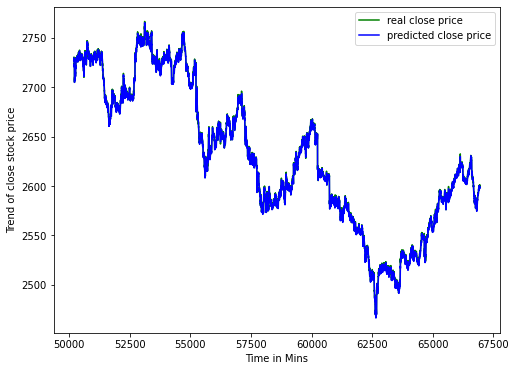

In [ ]:
plt.figure(figsize=(8,6))
real_close = dataset.Close[-16731: ]
real_close
plt.plot(real_close, 'g', label = 'real close price')
#plt.plot(trainPredictPlot, 'r', label = 'training close price')
plt.plot(testPredictPlot, 'b', label = 'predicted close price')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Mins')
plt.ylabel('Trend of close stock price')
plt.show()

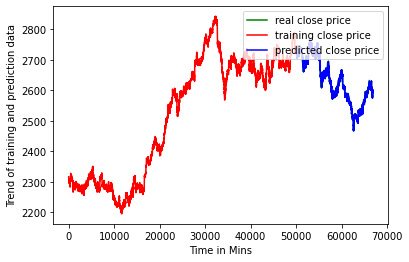

In [ ]:
# PLOT OF MAIN ORDSB VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(real_close, 'g', label = 'real close price')
plt.plot(trainPredictPlot, 'r', label = 'training close price')
plt.plot(testPredictPlot, 'b', label = 'predicted close price')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Mins')
plt.ylabel('Trend of training and prediction data')
plt.show()

In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Min Value:", np.asscalar(last_val))
print("Next Min Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Min Value: 2598.002685546875
Next Min Value: 2594.39111328125


#XGBoost

https://www.kaggle.com/mtszkw/using-xgboost-for-stock-trend-prices-prediction

In [ ]:
# IMPORTING DATASET 
#dataset = dataset.reindex(index = dataset.index[::-1])
dataset.head(3)

Open   Close    High     Low          ema
0  2319.0  2315.5  2319.0  2315.5  2315.500000
1  2316.5  2314.0  2316.5  2312.5  2314.375000
2  2311.5  2306.0  2312.0  2305.0  2308.576923

In [ ]:
def get_mean(df, col):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df.mean(axis=1) # len(mean_list) = len(df)
     
    # Add one timestep to the predictions
    #mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    #std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    #df_out[col + '_std'] = std_list
    
    return df_out

In [ ]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [ ]:
cols_list = [
"Open",
"Close",
"High",
"Low",
"ema"
]

for col in cols_list:
    ORDSB_avg = get_mean(dataset, col)
ORDSB_avg.head(3)

Open   Close    High     Low          ema     ema_mean
0  2319.0  2315.5  2319.0  2315.5  2315.500000  2316.900000
1  2316.5  2314.0  2316.5  2312.5  2314.375000  2314.775000
2  2311.5  2306.0  2312.0  2305.0  2308.576923  2308.615385

In [ ]:
df1_RDSB = ORDSB_avg
df1_RDSB.head(2)

Open   Close    High     Low       ema  ema_mean
0  2319.0  2315.5  2319.0  2315.5  2315.500  2316.900
1  2316.5  2314.0  2316.5  2312.5  2314.375  2314.775

In [ ]:
import plotly.graph_objects as go
test_size  = 0.20
valid_size = 0.05

test_split_idx  = int(df1_RDSB.shape[0] * (1-test_size))
valid_split_idx = int(df1_RDSB.shape[0] * (1-(valid_size+test_size)))

train_df1_RDSB  = df1_RDSB.loc[:valid_split_idx].copy()
valid_df1_RDSB  = df1_RDSB.loc[valid_split_idx+1:test_split_idx].copy()
test_df1_RDSB   = df1_RDSB.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df1_RDSB.index, y=train_df1_RDSB.ema_mean, name='Training'))
fig.add_trace(go.Scatter(x=valid_df1_RDSB.index, y=valid_df1_RDSB.ema_mean, name='Validation'))
fig.add_trace(go.Scatter(x=test_df1_RDSB.index,  y=test_df1_RDSB.ema_mean,  name='Test'))
fig.show()

In [ ]:
# Split into features and labels
y_train = train_df1_RDSB['ema_mean'].copy()
X_train = train_df1_RDSB.drop(['ema_mean'], 1)

y_valid = valid_df1_RDSB['ema_mean'].copy()
X_valid = valid_df1_RDSB.drop(['ema_mean'], 1)

y_test  = test_df1_RDSB['ema_mean'].copy()
X_test  = test_df1_RDSB.drop(['ema_mean'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50200 entries, 0 to 50199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    50200 non-null  float64
 1   Close   50200 non-null  float64
 2   High    50200 non-null  float64
 3   Low     50200 non-null  float64
 4   ema     50200 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
#### Fine-tune XGBoostRegressor
# %%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}
start = time.time() ####
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
print ('compilation time : ', time.time() - start) 

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 400, 'random_state': 42}
Best validation score = 0.9825003052242905
compilation time :  7513.5695543289185


In [ ]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [2726.27076911 2728.29025637 2729.76341879 2730.5211396  2730.9737132 ]
y_pred = [2726.1858 2728.304  2729.7717 2730.5244 2730.9028]


In [ ]:
from math import sqrt

In [ ]:
print(f'mse = {mean_squared_error(y_test, y_pred)}')
print(f'rmse = {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'mae = {mean_absolute_error(y_test, y_pred)}')
print(f'r2_score = {r2_score(y_test, y_pred)}')

mse = 0.10142798161032716
rmse = 0.3184775998564533
mae = 0.2062668412601337
r2_score = 0.9999752691002186


In [ ]:
y_pred.shape

(13386,)

In [ ]:
real_close_xgb = df1_RDSB.Close[-13386:]
predicted_prices = df1_RDSB.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
y=predicted_prices.Close

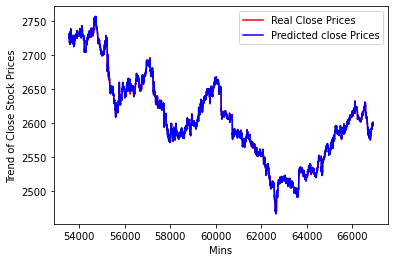

In [ ]:
import matplotlib.pyplot as plt
#predicted_stateful = y_pred
plt.plot(real_close_xgb, color = 'red',label = 'Real Close Prices')
#plt.plot(y_test, color = 'red',label = 'Training Close Prices')
plt.plot(y, color = 'blue', label  = 'Predicted close Prices')
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()

In [ ]:

from plotly.subplots import make_subplots
predicted_prices = df1_RDSB.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df1_RDSB.index, y=df1_RDSB.Close,
                         name='Real Close Price',
                         marker_color='Red'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.Close,
                         name='Predicted Close Price',
                         marker_color='Blue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_test,
                         name='Truth',
                         marker_color='Red',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         name='Prediction',
                         marker_color='Blue',
                         showlegend=False), row=2, col=1)
fig.show()

#Linear Regression

Reference: 
https://github.com/AdamLouly/Stockprediction/blob/master/stockpredi.ipynb

In [ ]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])
dataset.head(3)

Close    High        26ema        12ema          ema
0  2315.5  2319.0  2315.500000  2315.500000  2315.500000
1  2314.0  2316.5  2314.721154  2314.687500  2314.375000
2  2306.0  2312.0  2311.587728  2311.296767  2308.576923

In [ ]:
def get_mean(df, col):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df.mean(axis=1) # len(mean_list) = len(df)
     
    # Add one timestep to the predictions
    #mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    #std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    #df_out[col + '_std'] = std_list
    
    return df_out

In [ ]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [ ]:
cols_list = [
"Close",
"12ema",
"26ema",
"High",
"ema"
]

for col in cols_list:
    ORDSB_avg = get_mean(dataset, col)
ORDSB_avg.head(3)

Close    High        26ema        12ema          ema     ema_mean
0  2315.5  2319.0  2315.500000  2315.500000  2315.500000  2316.200000
1  2314.0  2316.5  2314.721154  2314.687500  2314.375000  2314.856731
2  2306.0  2312.0  2311.587728  2311.296767  2308.576923  2309.892284

In [ ]:
df1_RDSB = ORDSB_avg.drop(['High','12ema','26ema'],axis=1)
df1_RDSB.head()

Close          ema     ema_mean
0  2315.5  2315.500000  2316.200000
1  2314.0  2314.375000  2314.856731
2  2306.0  2308.576923  2309.892284
3  2306.5  2307.175000  2308.624607
4  2309.0  2308.396694  2309.172366

In [ ]:
#split into train and validation
train = df1_RDSB[:-1346]
valid = df1_RDSB[-1346:]

x_train = train.drop('ema_mean', axis=1)
y_train = train['ema_mean']
x_valid = valid.drop('ema_mean', axis=1)
y_valid = valid['ema_mean']

#implement linear regression
from sklearn.linear_model import LinearRegression
start = time.time() #####
model = LinearRegression()
model.fit(x_train,y_train)
print ('compilation time : ', time.time() - start) 

compilation time :  0.0024330615997314453


In [ ]:
#make predictions and find the rmse
preds = model.predict(x_valid)

In [ ]:
from sklearn import metrics
# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_valid, preds))  
print('mse:', metrics.mean_squared_error(y_valid, preds))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_valid, preds)))
print('r2_score:', metrics.r2_score(y_valid,preds)) 

mae: 0.48142235576014364
mse: 0.4491198969121931
rmse: 0.67016408208154
r2_score: 0.9981819388870551


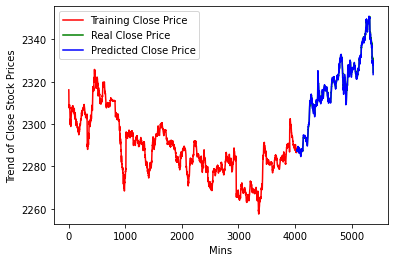

In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = df1_RDSB[-1346:].index
train.index = df1_RDSB[:-1346].index

plt.plot(train['ema_mean'], color ='r', Label= 'Training Close Price')
plt.plot(valid[['ema_mean']],color = 'g', label = 'Real Close Price' )
plt.plot(valid[['Predictions']],color = 'b', label = 'Predicted Close Price' )
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()

#LR2

reference: https://github.com/mediasittich/Predicting-Stock-Prices-with-Linear-Regression/blob/master/Predicting%20Stock%20Prices%20with%20Linear%20Regression.ipynb

In [ ]:
df1_RDSB['Dates'] = dataset_S1['Dates']
df1_RDSB = ORDSB_avg.drop(['Open','High','Close','Low','ema'],axis=1)
# IMPORTING DATASET 
#df1_RDSB = df1_RDSB.reindex(index = df1_RDSB.index[::-1])
df1_RDSB.head()

ema_mean               Dates
0  2316.900000 2018-02-14 08:00:00
1  2314.775000 2018-02-14 08:01:00
2  2308.615385 2018-02-14 08:02:00
3  2306.935000 2018-02-14 08:03:00
4  2308.779339 2018-02-14 08:04:00

In [ ]:
# Import package for linear model
from sklearn.linear_model import LinearRegression

In [ ]:
# Split data into train and test set: 75% / 25%
train, test = train_test_split(df1_RDSB, test_size=0.25)

In [ ]:
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['ema_mean']

In [ ]:
# Create LinearRegression Object
start = time.time()
model = LinearRegression()
# Fit linear model using the train data set
pred_LR = model.fit(X_train, y_train)
print ('compilation time : ', time.time() - start)

compilation time :  0.011877059936523438


In [ ]:
#model evaluation
# The coefficient
print('Slope: ', np.asscalar(np.squeeze(model.coef_)))
# The Intercept
print('Intercept: ', model.intercept_)

Slope:  0.0067037412378493835
Intercept:  2321.6005965636064


Interpreting the coefficients:

The slope coefficient tells us that with a 1 unit increase in date the closing price increases by 0.0276 $
The intercept coefficient is the price at wich the closing price measurement started, the stock price value at date zero

In [ ]:
predicted_prices = df1_RDSB.loc[test_split_idx+1:].copy()
predicted_prices['ema_mean'] = pred_LR
y1=predicted_prices.ema_mean

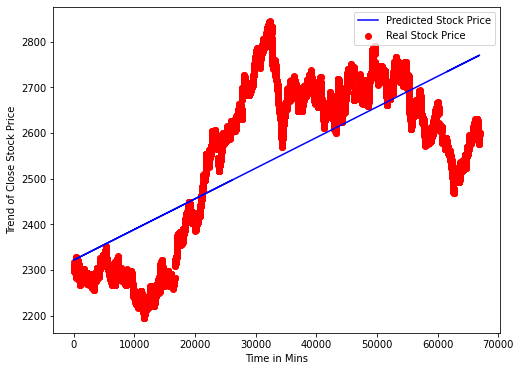

In [ ]:
# Train set graph
plt.figure(1, figsize=(8,6))
plt.scatter(X_train, y_train, color='r', label='Real Stock Price')
plt.plot(X_train, model.predict(X_train), color='b', label='Predicted Stock Price')
plt.xlabel('Time in Mins')
plt.ylabel('Trend of Close Stock Price')
plt.legend()
plt.show()

In [ ]:
# Create test arrays
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['ema_mean']

In [ ]:
# Generate array with predicted values
y_pred = model.predict(X_test)

In [ ]:
df1_RDSB['LRPred'] = pd.DataFrame(y_pred)
df1_RDSB.shape

(66932, 3)

In [ ]:
df1_RDSB.head()

ema_mean               Dates       LRPred
0  2316.900000 2018-02-14 08:00:00  2665.341632
1  2314.775000 2018-02-14 08:01:00  2483.603207
2  2308.615385 2018-02-14 08:02:00  2525.970852
3  2306.935000 2018-02-14 08:03:00  2700.147457
4  2308.779339 2018-02-14 08:04:00  2631.085515

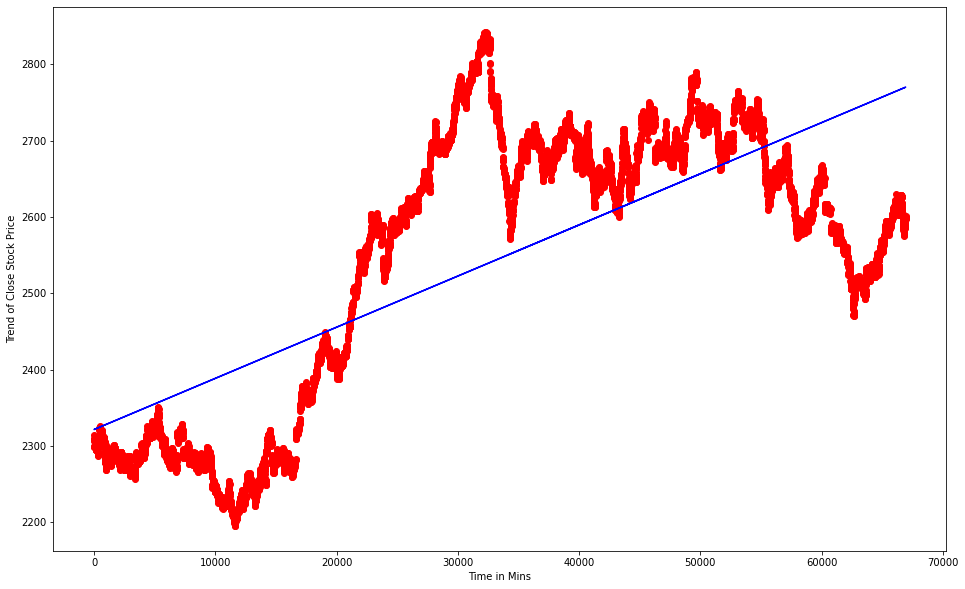

In [ ]:
#model performance over the whole test data set.
# Plot fitted line, y test
plt.figure(1, figsize=(16,10))
plt.plot(X_test, model.predict(X_test), color='b', label='Predicted Stock Price')
plt.scatter(X_test, y_test, color='r', label='Real Stock Price')

plt.xlabel('Time in Mins')
plt.ylabel('Trend of Close Stock Price')

plt.show()

In [ ]:
from sklearn import metrics
# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_test, y_pred))  
print('mse:', metrics.mean_squared_error(y_test, y_pred))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2_score:', metrics.r2_score(y_test, y_pred)) 

mae: 106.1198200039831
mse: 15512.755679806269
rmse: 124.55021348759811
r2_score: 0.5220802105367233


#KNN

reference: 
https://github.com/AdamLouly/Stockprediction/blob/master/stockpredi.ipynb

In [ ]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
df1_RDSB = ORDSB_avg.drop(['Dates'],axis=1)
#df1_RDSB = df1_RDSB.reindex(index = df1_RDSB.index[::-1])
df1_RDSB.head()

Open   Close    High     Low          ema     ema_mean
0  2319.0  2315.5  2319.0  2315.5  2315.500000  2316.900000
1  2316.5  2314.0  2316.5  2312.5  2314.375000  2314.775000
2  2311.5  2306.0  2312.0  2305.0  2308.576923  2308.615385
3  2306.5  2306.5  2309.5  2305.0  2307.175000  2306.935000
4  2309.0  2309.0  2309.0  2308.5  2308.396694  2308.779339

In [ ]:
#split into train and validation
train = df1_RDSB[:-16731]
valid = df1_RDSB[-16731:]

x_train = train.drop('ema_mean', axis=1)
y_train = train['ema_mean']
x_valid = valid.drop('ema_mean', axis=1)
y_valid = valid['ema_mean']

In [ ]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
start = time.time() #####
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
print ('compilation time : ', time.time() - start) 
preds_KNN = model.predict(x_valid)

compilation time :  4.343964099884033


In [ ]:
from sklearn import metrics
# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_valid, preds_KNN))  
print('mse:', metrics.mean_squared_error(y_valid, preds_KNN))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_valid, preds_KNN)))
print('r2_score:', metrics.r2_score(y_valid, preds_KNN)) 

mae: 98.08203254807903
mse: 14015.696209577241
rmse: 118.38790567273855
r2_score: -1.6431744609523111


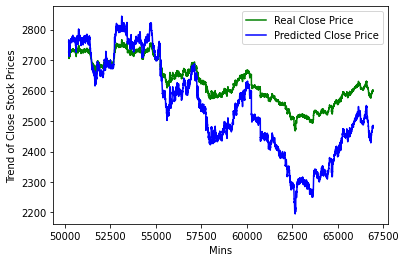

In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds_KNN

valid.index = df1_RDSB[-16731:].index
train.index = df1_RDSB[:-16731].index

#plt.plot(train['ema_mean'], color ='r', Label= 'Training Close Price')
plt.plot(valid[['ema_mean']],color = 'g', label = 'Real Close Price' )
plt.plot(valid[['Predictions']],color = 'b', label = 'Predicted Close Price' )
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()

#SVR

reference
https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

http://www.saedsayad.com/support_vector_machine_reg.htm?source=post_page-----8eb3acf6d0ff----------------------


https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72

https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf

https://www.researchgate.net/publication/255995594_Predicting_Stock_Market_Price_Using_Support_Vector_Regression#:~:text=In%20this%20study%2C%20support%20vector,to%20predict%20stock%20market%20trend.&text=It%20can%20produce%20good%20prediction,parameters%20can%20be%20determined%20properly.

In [ ]:
from sklearn.svm import SVR
start = time.time() #####
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(x_train,y_train )
print ('compilation time : ', time.time() - start) 

compilation time :  487.0455548763275


In [ ]:
preds_SVR = model.predict(x_valid)

# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_valid, preds_SVR))  
print('mse:', metrics.mean_squared_error(y_valid, preds_SVR))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_valid, preds_SVR)))
print('r2_score:', metrics.r2_score(y_valid, preds_SVR)) 

mae: 98.08203254807903
mse: 14015.696209577241
rmse: 118.38790567273855
r2_score: -1.6431744609523111


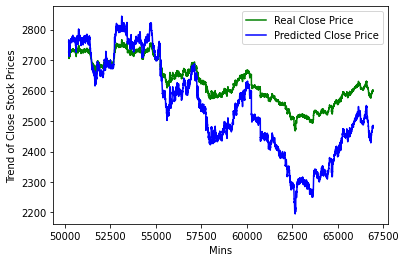

In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds_SVR

valid.index = df1_RDSB[-16731:].index
train.index = df1_RDSB[:-16731].index

#plt.plot(train['ema_mean'], color ='r', Label= 'Training Close Price')
plt.plot(valid[['ema_mean']],color = 'g', label = 'Real Close Price' )
plt.plot(valid[['Predictions']],color = 'b', label = 'Predicted Close Price' )
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()